In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *

import pickle


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

### Preparing train 
### Test data   
### Building Resnet model

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


==> Preparing data..


100%|███████████████████████| 170498071/170498071 [00:04<00:00, 41142007.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
==> Building model..


### Training function

In [4]:
def train(epoch, net):
    
    '''
    this function train net on training dataset
    '''

    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

### Test function

In [5]:
def test(epoch, net):

    '''
    This function evaluate net on test dataset
    '''

    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss/len(testloader)

In [6]:
train_losses=[]
test_losses=[]
epochs=1

for epoch in range(0,epochs):
    train_losses.append(train(epoch, net))
    test_losses.append(test(epoch, net))
    scheduler.step()

In [7]:
print('Accuracy of the network on the test images: %d %%' % (acc))

Accuracy of the network on the test images: 52 %


## FGSM

In [14]:
imgloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

dataiter = iter(imgloader)
org_images, org_labels = next(dataiter)  

In [15]:
org_labels = org_labels.to(device)
org_images = org_images.to(device)
print(org_images.shape)
outputs= net(org_images)
output=outputs.to(device)
print(outputs.shape)
_, predicted = torch.max(outputs.data, 1)

torch.Size([100, 3, 32, 32])
torch.Size([100, 10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


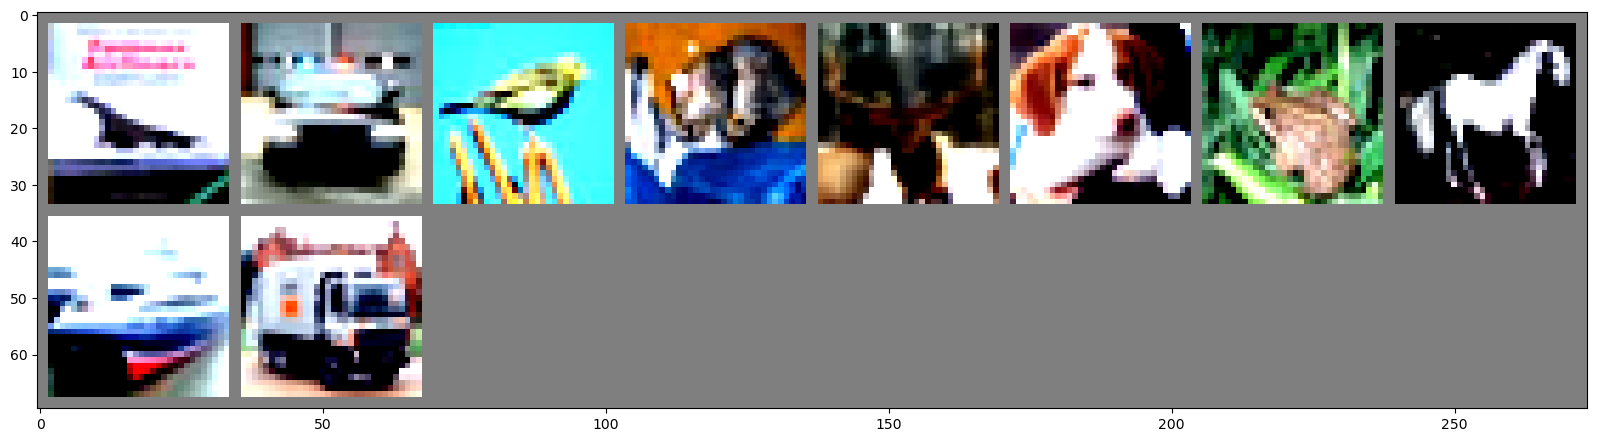

In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


samples = []
samples_labels = []
samples_pred = []
selected = [3,66,67,0,26,16,4,13,1,11]

for i in selected:
  samples.append(org_images[i])
  samples_labels.append(org_labels[i])
  samples_pred.append(outputs[i])
samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)
imshow(torchvision.utils.make_grid(samples.cpu()))

### FGSM attack function

In [17]:
def FGSM(net, x, y, eps):
        '''
        inputs:
            net: the network through which we pass the inputs
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            eps: perturbation budget

        outputs:
            x_adv : the adversarial example constructed from x
            h_adv: output of the last softmax layer when applying net on x_adv 
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''

        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert


### Creating adversarial examples from samples with the FGSM attack


from left to right: (1/eps) perturbation, original image, adversarial example



[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 0 adversary label: 1


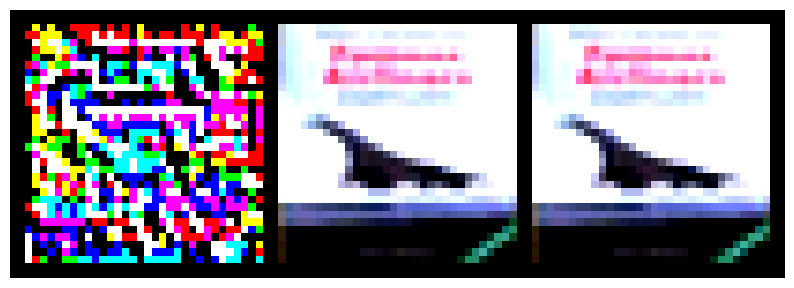

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 1 adversary label: 0


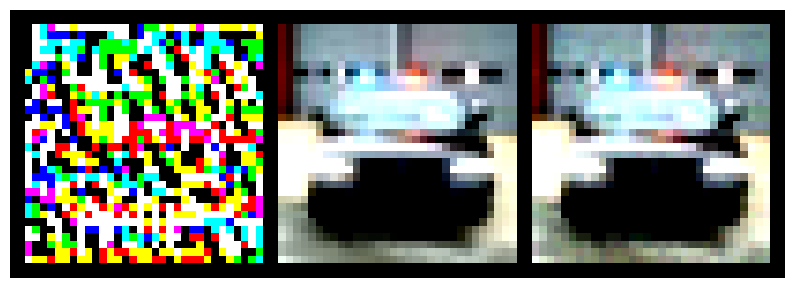

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 2 adversary label: 1


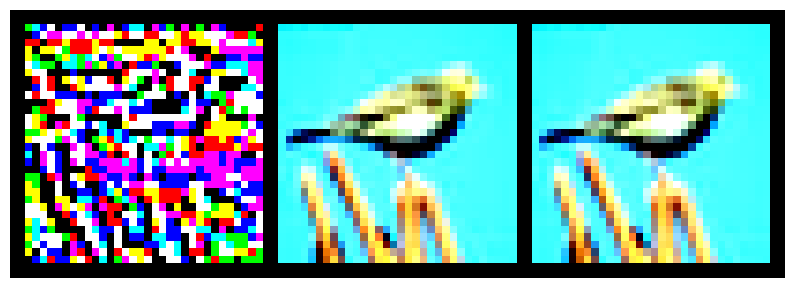

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 3 adversary label: 5


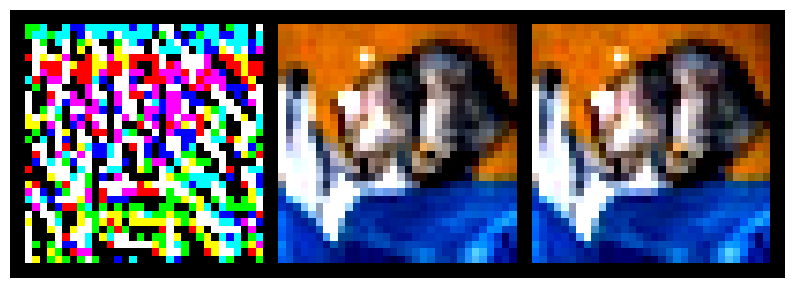

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 4 adversary label: 2


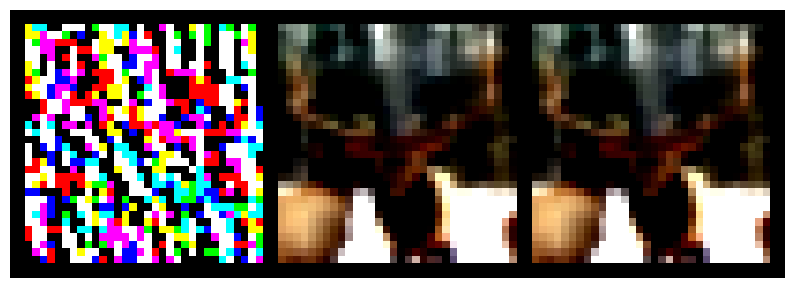

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 5 adversary label: 7


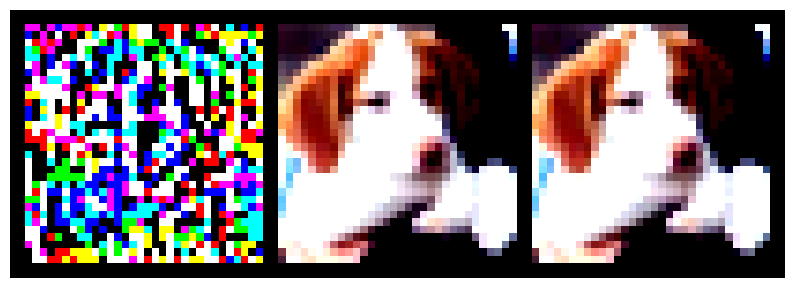

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 6 adversary label: 4


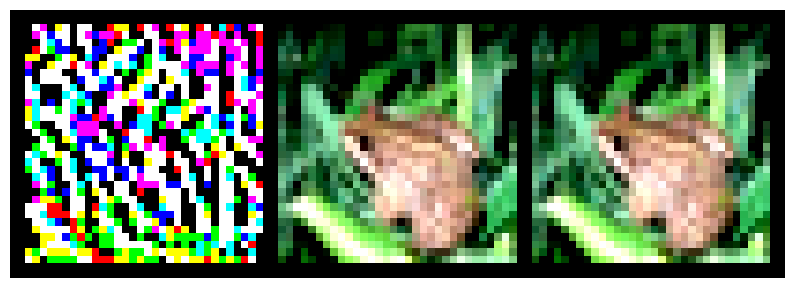

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 7 adversary label: 1


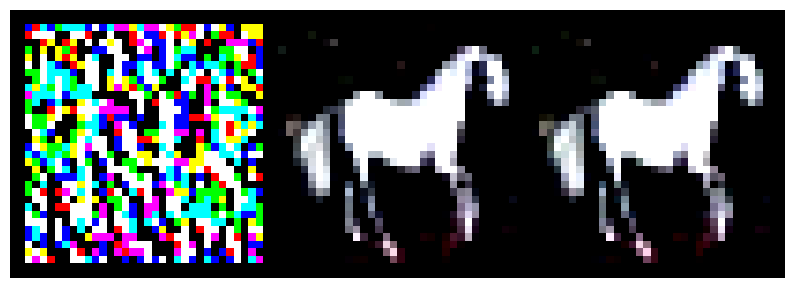

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 8 adversary label: 1


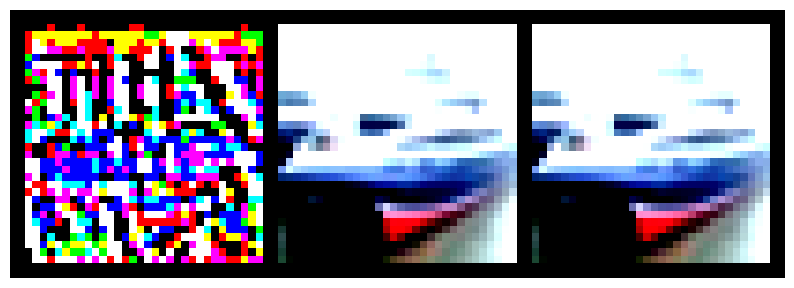

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 9 adversary label: 1


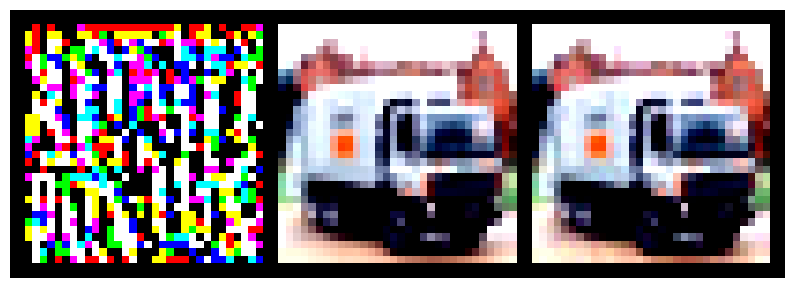

In [18]:
print()
print('from left to right: (1/eps) perturbation, original image, adversarial example')
print()
for i in selected:
    eps=1/255
    while True:
        x_adv, h_adv, y_adv, pert=FGSM(net, org_images[i].unsqueeze_(0),org_labels[i].unsqueeze_(0),eps)
        if y_adv.item()==org_labels[i].item():
            eps=eps+(1/255)
        else:
            break
    print("true label:", org_labels[i].item(), "adversary label:", y_adv.item())
    triple=[]
    with torch.no_grad():
        triple.append((1/eps)*pert.detach().clone().squeeze_(0))
        triple.append(org_images[i])
        triple.append(x_adv.detach().clone().squeeze_(0))
        triple=torch.stack(triple)
        grid = torchvision.utils.make_grid(triple.cpu()/2+0.5)
        plt.figure(figsize=(10,10))
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()

    

### Adversarial Training with FGSM

In [19]:
print('==> Building new model..')
net_adv = ResNet18()
net_adv = net_adv.to(device)
if device == 'cuda':
    net_adv = torch.nn.DataParallel(net_adv)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_adv = optim.SGD(net_adv.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=200)


==> Building new model..


In [20]:
def train_adv(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)

        cost = criterion(h_, targets)

        net.zero_grad()
        cost.backward()

        pert= eps*inputs_.grad.detach().sign()
        x_adv = inputs_ + pert

        optimizer_adv.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

In [21]:
train_losses_adv=[]
test_losses_adv=[]
epochs=1

for epoch in range(0,epochs):
    train_losses_adv.append(train_adv(epoch, net_adv))
    test_losses_adv.append(test(epoch, net_adv))
    scheduler_adv.step()

In [22]:
print('Accuracy of the network on unperturbed test images: %d %%' % (acc))

Accuracy of the network on unperturbed test images: 48 %


In [24]:
def test_adv(net, net_adv, eps):
    accuracy=0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM (net, inputs, targets, eps)
            
        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [25]:
for eps in [4/355, 8/255, 12/255]:
    accuracy=test_adv(net, net_adv, eps)
    print("epsilon:", eps, "accuracy:", accuracy)

epsilon: 0.011267605633802818 accuracy: 47.7
epsilon: 0.03137254901960784 accuracy: 46.9
epsilon: 0.047058823529411764 accuracy: 46.3


### Targeted FGSM

In [26]:
def FGSM_targeted(net,x,y,t,eps):
        '''
        inputs:
            net: the neural network through which we pass the input
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            t: target label
            eps: perturbation budget

        outputs:
            x_adv : the adversarial example constructed from x
            h_adv: output of the last softmax layer when applying net on x_adv 
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''
        
        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)-criterion(h_,t)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert  

In [27]:
def test_adv_targ(net,model,eps,mode='largest_prob'):
    acc=0
    net.train()
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        if mode=='largest_prob':
            out=net(inputs)
            _,largest=torch.kthvalue(out,10,1)
            _,second_largest=torch.kthvalue(out,9,1)
            condition=largest-targets
            target_adv=torch.where(condition==0,second_largest, largest)
        else:
            out=net(inputs)
            _,smallest=torch.kthvalue(out,1,1)
            _,second_smallest=torch.kthvalue(out,2,1)
            condition=smallest-targets
            target_adv=torch.where(condition==0,second_smallest, smallest)

        x_adv, h_adv, y_adv, pert =FGSM_targeted(net,inputs,targets,target_adv,eps)

        with torch.no_grad():
                outputs = model(x_adv)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return acc

In [28]:
eps=8/255
acc1=test_adv_targ(net,net,eps)
acc2=test_adv_targ(net,net_adv,eps)
print("accuracy of naturally trained model against FGSM_targeted attack:",acc1)
print("accuracy of adversarially trained model against FGSM_targeted attack:",acc2)


accuracy of naturally trained model against FGSM_targeted attack: 36.19
accuracy of adversarially trained model against FGSM_targeted attack: 46.9


In [29]:
eps=8/255
acc1=test_adv_targ(net,net,eps, mode='smallest_prob')
acc2=test_adv_targ(net,net_adv,eps, mode='smallest_prob')
print("accuracy of naturally trained model against FGSM_targeted attack:",acc1)
print("accuracy of adversarially trained model against FGSM_targeted attack:",acc2)


accuracy of naturally trained model against FGSM_targeted attack: 47.9
accuracy of adversarially trained model against FGSM_targeted attack: 47.11


### PGD attack function

In [30]:
def PGD(net,x,y,alpha,epsilon,iter):
    '''
    inputs:
        net: the network through which we pass the inputs
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        alpha: step size
        epsilon: perturbation budget 
        iter: number of iterations in the PGD algorithm

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    delta = torch.zeros_like(x, requires_grad=True)
    for i in range(iter):
        criterion=nn.CrossEntropyLoss()
        loss = criterion(net(x + delta), y)
        loss.backward()
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _,y_adv = torch.max(h_adv.data,1)
    return x_adv, h_adv, y_adv, pert

### Adversarial Training with PGD

In [31]:
print('==> Building new model..')
net_pgd = ResNet18()
net_pgd = net_pgd.to(device)
if device == 'cuda':
    net_pgd = torch.nn.DataParallel(net_pgd)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_pgd = optim.SGD(net_pgd.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_pgd = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pgd, T_max=200)


==> Building new model..


In [32]:
def train_pgd(epoch, net, alpha, epsilon, iter):
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv,_,_,_ = PGD(net,inputs,targets,alpha,epsilon,iter)

        optimizer_pgd.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pgd.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

In [33]:
train_losses_pgd=[]
test_losses_pgd=[]
epochs=1
alpha=3/255
epsilon=8/255
iter=3
for epoch in range(0,epochs):
    train_losses_pgd.append(train_pgd(epoch, net_pgd, alpha, epsilon, iter))
    test_losses_pgd.append(test(epoch, net_pgd))
    scheduler_pgd.step()

In [34]:
print('Accuracy of the network on the test images: %d %%' % (acc))

Accuracy of the network on the test images: 64 %


### Evaluating the adversarially-trained model with PGD against PGD attack on test data

In [37]:
def test_PGD(net,net_pgd,alpha,eps,iter):
    acc=0
    net.train()
    net_pgd.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            x_adv,_,_,_=PGD(net,inputs,targets,alpha,eps,iter)

            with torch.no_grad():
                outputs = net_pgd(x_adv)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return acc

In [38]:
alpha=3/255
eps=8/255
acc1_pgd=[]
for iter in [3,7,12]:
    acc=test_PGD(net,net_pgd,alpha,eps,iter)
    print("accuracy of net_pgd against PGD attack with iters=",iter,": ",acc)

accuracy of net_pgd against PGD attack with iters= 3 :  64.07
accuracy of net_pgd against PGD attack with iters= 7 :  63.86
accuracy of net_pgd against PGD attack with iters= 12 :  63.46
